# Parameters

In [1]:
seed = 70        # seed for NMF topic model
num_topics = 12

labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6     # seed for t-SNE visualization
vis_angle = 135  # rotation angle for visualization

# Scopus Query
#query = 'TITLE-ABS-KEY ( ddos  AND  ( "collab*"  OR  "coop*" ) )'
query = 'TITLE-ABS-KEY ( ddos  AND  ( "collab*"  OR  "coop*" ) )  AND  DOCTYPE ( ar  OR  cp ) '

# Imports

In [2]:
#Scopus imports
import platform, sys
import random
import gensim
import pybliometrics.scopus as scopus
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction

import requests
import ipywidgets as widgets
import time 
import datetime
import requests

from bs4 import BeautifulSoup as bs
from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')

import logging
logging.getLogger().setLevel(logging.INFO)

In [3]:
import smart_open,  platform
#print(platform.platform())
#print("Python", sys.version)
#print("smart_open", smart_open.__version__)

# some python 3 trickery
import sys
if sys.version_info[0] >= 3:
    unicode = str

In [4]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

## Preparing Selenium to use (Google Scholar Crawler)


In [5]:
# !brew cask install chromedriver (check if it's the same browser version)
# https://selenium-python.readthedocs.io/installation.html#drivers
# !pip install selenium

# Import your newly installed selenium package
from selenium import webdriver

# Now create an 'instance' of your driver
# This path should be to wherever you downloaded the driver

# driver = webdriver.Chrome(executable_path="/usr/local/bin/chromedriver")
# A new Chrome (or other browser) window should open up

# Now just tell it wherever you want it to go
#driver.get("http://penta.ufrgs.br")
#
# Selenium command example
#driver.title
#driver.back()
#driver.forward()
#driver.save_screenshot('./q0.png') 
#driver.page_source
#
# How to navigate into pages
#driver.get("http://penta.ufrgs.br")
#driver.page_source
#
#driver.find_element_by_partial_link_text('Asilo')
#driver.find_element_by_partial_link_text('Asilo').click()
#driver.find_element_by_partial_link_text('Como ajudar').click()
#
# You also may want to type into fields
# Try CMD+Shift+C on browser
#driver.find_element_by_name('textbox).send_keys('type this in, robot')
#
#CLOSE SELETIUM
#driver.close()

# Perform SCOPUS query (Getting a paper's list)

In [6]:
eids = scopus.ScopusSearch(query).get_eids()
random.seed(0)
random.shuffle(eids)

bar = widgets.IntProgress(
    min=0, 
    max=len(eids), 
    description='Loading')
display(bar)

print('query: {} ({} results)'.format(query, len(eids)))

papers = []
for eid in eids:
    papers.append(scopus.AbstractRetrieval(eid, view='FULL'))
    bar.value += 1
    bar.description = str(bar.value)

print('scopus returned {} results'.format(len(papers)))

# Filter on article type
# ar = article, cp = conference proceeding, re = review
print(set([p.srctype for p in papers]))

# Filter on citation type
#papers = [p for p in papers if p.citationType in ('ar', 'cp', 're') or p.citationType is None]

# Filter on date
#papers = [p for p in papers if int(p.coverDate[:4]) <= 2018]

print('{} papers remaining'.format(len(papers)))

IntProgress(value=0, description='Loading', max=343)

query: TITLE-ABS-KEY ( ddos  AND  ( "collab*"  OR  "coop*" ) )  AND  DOCTYPE ( ar  OR  cp )  (343 results)
scopus returned 343 results
{'k', 'j', None, 'p', 'd'}
343 papers remaining


## Save Scopus Result on CVS

In [7]:
df = pd.DataFrame()

In [8]:
for p in papers: 
    df = df.append({
        'year':p.coverDate[:4], 
        'eid':p.eid,              # Elsevier_Id
        'doi':p.doi, 
        'title':p.title, 
        'scopus':p.citedby_count, # Scopus Citations
        'scholar':None,           # Google Scholar Citations
        'abstract':p.abstract, 'link':p.scopus_link
    },ignore_index=True)

In [9]:
print("TOTAL ENTRIES:",len(df))
df.head(2)

TOTAL ENTRIES: 343


,abstract,doi,eid,link,scholar,scopus,title,year
0,Distributed denial-of-service (DDoS) attacks h...,10.1109/ICON.2002.1033348,2-s2.0-33745278421,https://www.scopus.com/inward/record.uri?partn...,None,27.0,Engineering of a global defense infrastructure...,2002
1,"© 2019 John Wiley & Sons, Ltd.The amount of wi...",10.1002/dac.4241,2-s2.0-85075171039,https://www.scopus.com/inward/record.uri?partn...,None,0.0,Dual-collaborative DoS/DDoS mitigation approac...,2020


In [10]:
# Save to csv file
filename_log = './log/ddos_coop_collab_' + time.strftime("%Y-%m-%dT%H%M%S") + '.csv'
filename = 'ddos_coop_collab_citations' + '.csv'

#date=datetime.datetime.now().replace(microsecond=0).isoformat()
#df.to_csv(filename, encoding='utf-8', index=False)

df.to_csv(filename_log, index=False)
df.to_csv(filename, index=False)

## Open Google Scholar and type query

In [15]:
## Read biblio from Scopus CVS
# In case Crawler/reCaptcha problems you can restart from here
# CSV save intermediary states as google captcha permits

df = pd.read_csv('ddos_coop_collab_citations.csv')
print("TOTAL ENTRIES:",len(df))
df.head(2)

TOTAL ENTRIES: 343


,abstract,doi,eid,link,scholar,scopus,title,year
0,Distributed denial-of-service (DDoS) attacks h...,10.1109/ICON.2002.1033348,2-s2.0-33745278421,https://www.scopus.com/inward/record.uri?partn...,55.0,27.0,Engineering of a global defense infrastructure...,2002
1,"© 2019 John Wiley & Sons, Ltd.The amount of wi...",10.1002/dac.4241,2-s2.0-85075171039,https://www.scopus.com/inward/record.uri?partn...,0.0,0.0,Dual-collaborative DoS/DDoS mitigation approac...,2020


### Use Selenium - I think is better way to solve captchas

In [26]:
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
#from selenium.common.exceptions import *

# get the path of ChromeDriverServer 
chrome_driver_path = "/usr/local/bin/chromedriver"

# create a new Chrome session and open Google Scholar page
driver = webdriver.Chrome(chrome_driver_path)
driver.get("https://scholar.google.com")

# Find textbox and submit text
#search_field = driver.find_element_by_name("q")
#search_field.send_keys("a search term\n")

### Get  Google SCHOLAR citations from SCOPUS selection

In [27]:
scholar_url = 'https://scholar.google.com/scholar?as_sdt=0%2C5&btnG=&hl=en&inst=5726176096060060532&q='
msg_cited = ['Cited', 'Geciteerd', 'Citado']
recaptcha = False

bar = widgets.IntProgress(
    min=0, 
    max=len(df), 
    description='Loading')
display(bar)

for i in df.index:
    bar.value += 1
    bar.description = str(bar.value)
    
    if (pd.notnull(df.scholar.loc[i])):
        #print ('[', i , ']', '...skipping..')
        continue
        
    p = df.loc[i]
    url = scholar_url + '"'+ p.title + '"'
    driver.get(url)
    
    soup = bs(driver.page_source, 'html.parser')
    
    # Must change here to multilingual too
    cited_by = soup.select_one('a:contains("Cited by")').text if soup.select_one('a:contains("Cited by")') is not None else 'No citation count'
    #print (cited_by)

    if (cited_by.split()[0] in msg_cited) :
        # Citation found (update dataframe)
        scholar_citation = re.sub('[^0-9]', '', cited_by)
        df.at[i,'scholar']=scholar_citation

    else:
        # Citation not found (can be lang, captcha or zero citation)
        scholar_citation = 0
        recaptcha = True
        
        #some_google_answers = ['Related', 'results', 'entire web', 'Suggestions', 'versions', 'Related articles']
        #for txt in some_google_answers:
        #    if ( soup.select_one('a:contains(txt)')) :
        #        # There is no citations for sure
        #        recaptcha = False 
        #        df.at[i,'scholar']=scholar_citation
        #        print ('Found: ', txt)
           
        #if ( soup.find (text=re.compile(re.escape(p.title))) ):
        if ( soup.find(text=re.compile( re.escape(p.title[:20]),re.I)) ):
            # I have title, zero citation = not in recaptcha
            recaptcha = False 
            df.at[i,'scholar']=scholar_citation
        
    #print (scholar_citation)  
    print ('[', i , recaptcha, ']', p.scopus, scholar_citation, p.title[0:20], sep="\t")
    
    #time.sleep(random.randint(5, 30))


IntProgress(value=0, description='Loading', max=343)

[	204	False	]	5.0	4	Deteriorating distri
[	205	False	]	6.0	10	OPERA: An open-sourc
[	206	False	]	30.0	71	Distributed denial-o
[	207	False	]	2.0	1	Evaluating a blockch
[	208	False	]	0.0	1	Mitigating DDoS Floo
[	209	False	]	20.0	35	Agent-based simulati
[	210	False	]	32.0	54	A blockchain-based a
[	211	False	]	1.0	1	A collaborative intr
[	212	False	]	1.0	1	History-based thrott
[	213	False	]	9.0	14	Global detection of 
[	214	False	]	0.0	2	Intrusion detection 
[	215	False	]	4.0	7	Toward Mitigation-As
[	216	False	]	6.0	8	An efficient analyti
[	217	False	]	13.0	8	A model of network d
[	218	False	]	23.0	26	A Game Theory Based 
[	219	False	]	543.0	953	A survey of defense 
[	220	False	]	0.0	0	A survey on distribu
[	221	False	]	4.0	3	A novel collaborativ
[	222	False	]	1.0	0	IP traceback method 
[	223	False	]	0.0	3	Source address filte
[	224	False	]	0.0	0	Collaborative detect
[	225	False	]	5.0	3	Efficient and benefi
[	226	False	]	1.0	5	Available bandwidth 
[	227	False	]	15.0	27	Detecting and reacti

In [28]:
# Save intermediary state before restart searching machanism to update last searches
df.to_csv('ddos_coop_collab_citations.csv',index=False)

In [29]:
df

,abstract,doi,eid,link,scholar,scopus,title,year
0,Distributed denial-of-service (DDoS) attacks h...,10.1109/ICON.2002.1033348,2-s2.0-33745278421,https://www.scopus.com/inward/record.uri?partn...,55.0,27.0,Engineering of a global defense infrastructure...,2002
1,"© 2019 John Wiley & Sons, Ltd.The amount of wi...",10.1002/dac.4241,2-s2.0-85075171039,https://www.scopus.com/inward/record.uri?partn...,0.0,0.0,Dual-collaborative DoS/DDoS mitigation approac...,2020
2,© 2014 IEEE.A domain name system (DNS) is one ...,10.1109/JIOT.2019.2947659,2-s2.0-85079754375,https://www.scopus.com/inward/record.uri?partn...,0.0,0.0,Load Distributed and Benign-Bot Mitigation Met...,2020
3,As more and more services are provided by serv...,10.1142/S012905411100857X,2-s2.0-80051675657,https://www.scopus.com/inward/record.uri?partn...,9.0,0.0,Trawling traffic under attack overcoming ddos ...,2011
4,© Springer Nature Singapore Pte Ltd. 2019.Dist...,10.1007/978-981-13-3143-5_33,2-s2.0-85058291104,https://www.scopus.com/inward/record.uri?partn...,2.0,0.0,Cooperative Mitigation of DDoS Attacks Using a...,2019
...,...,...,...,...,...,...,...,...
338,The current Internet is vulnerable to attacks ...,10.1109/MMIT.2008.26,2-s2.0-70349593755,https://www.scopus.com/inward/record.uri?partn...,9.0,4.0,Mitigation of DDoS attacks through Pushback an...,2008
339,© 2015 IEEE.DoS attacks are significant issues...,10.1109/ICATCCT.2015.7456891,2-s2.0-84966665224,https://www.scopus.com/inward/record.uri?partn...,6.0,2.0,A survey for restricting the DDOS traffic floo...,2016
340,© 2019 Association for Computing Machinery.Dri...,10.1145/3342280.3342300,2-s2.0-85071930693,https://www.scopus.com/inward/record.uri?partn...,1.0,1.0,Cooperative signaling of DDoS attacks in a blo...,2019
341,Computers and Internet have evolved into neces...,10.1145/2179298.2179388,2-s2.0-84862882993,https://www.scopus.com/inward/record.uri?partn...,1.0,0.0,Security experimentation using operational sys...,2011


# Analysis

### Prepare ABSTRACT text for word analisys

In [30]:
texts = []
for p in papers:
    text = (p.title or '') + ' ' + (p.abstract or '')
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

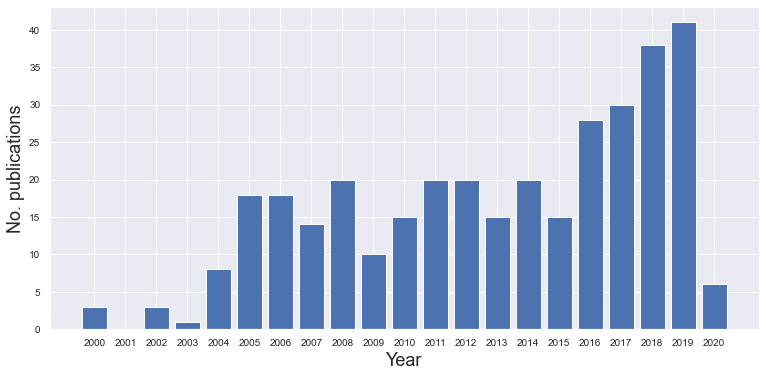

In [31]:
# Publications per year
year_count = defaultdict(int)

for p in papers:
    year_count[int(p.coverDate[:4])] += 1
       
years = range(2000, 2021)

prepare_fig(1.8, 1.8)
plt.ylabel("No. publications",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.bar(
    years,
    [year_count[y] for y in years])
plt.xticks(years);
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.savefig('years_ad.pdf')

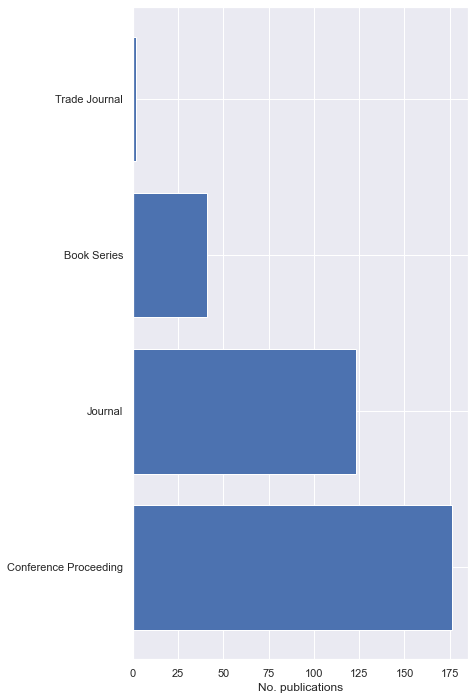

In [32]:
# Publications per aggregation type
def plot_statistic(fun):
    count = defaultdict(int)

    for p in papers:
        for key in fun(p):
            if key:
                count[unicode(key)] += 1

    top_keys = top_k(count, 50)

    prepare_fig(1, 4)
    plt.xlabel("No. publications")
    plt.barh(
        range(len(top_keys)),
        [count[a] for a in top_keys])
    plt.yticks(
        range(len(top_keys)), 
        [key[:50] for key in top_keys])
    plt.show()

plot_statistic(lambda p: [p.aggregationType])

[Author(auid='55992325100', indexed_name='Wang X.', surname='Wang', given_name='Xiuli', affiliation=['60013131'])]
-----
-----
[[https://www.scopus.com/inward/record.uri?partnerID=HzOxMe3b&scp=84876816378&origin=inward][2-s2.0-84876816378]]  Xiuli Wang, Defense strategy against DDoS attacks based on congestion control and resource regulation, Huazhong Keji Daxue Xuebao (Ziran Kexue Ban)/Journal of Huazhong University of Science and Technology (Natural Science Edition), 40(SUPPL.1), pp. 307-310(2012). https://www.scopus.com/inward/record.uri?partnerID=HzOxMe3b&scp=84876816378&origin=inward, cited 1 times (Scopus).
  Affiliations:
   Central University of Finance and Economics
-----


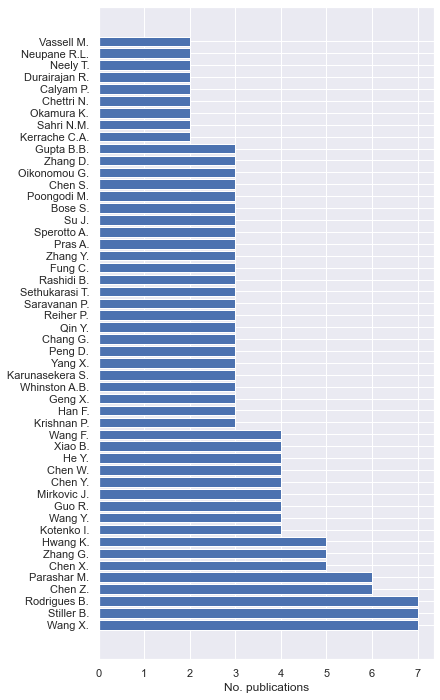

In [33]:
# Publications per author
print (p.authors)
print ("-----")
lambda p: set(a.indexed_name for a in p.authors or [])
print ("-----")

print (p)
print ("-----")

plot_statistic(lambda p: set(a.indexed_name for a in p.authors or []))

In [34]:
# Publications per institute
def clean_affiliation(name):
    name = unicode(name).title()
    pairs = [
        ['University', 'U'],
        ['universidad', 'U'],
        ['universidade', 'U'],
        ['universiteit', 'U'],
        ['Universitat', 'U'],
        ['Laboratories', 'Lab'],
        ['Laboratory', 'Lab'],
        ['National', 'Nat'],
        ['Corporation', 'Corp'],
        ['Technology', 'Tech'],
        ['Institute', 'Inst'],
    ]
    
    for needle, replacement in pairs:
        name = name.replace(needle, replacement)
    return name

print ("affiliation", a.indexed_name)
#ver linha abaixo
#plot_statistic(lambda p: set(clean_affiliation(a.affiliation_name) for a in p.affiliation))
plot_statistic(lambda p: [p.affiliation_name]

SyntaxError: unexpected EOF while parsing (<ipython-input-34-7aa4134037dd>, line 25)

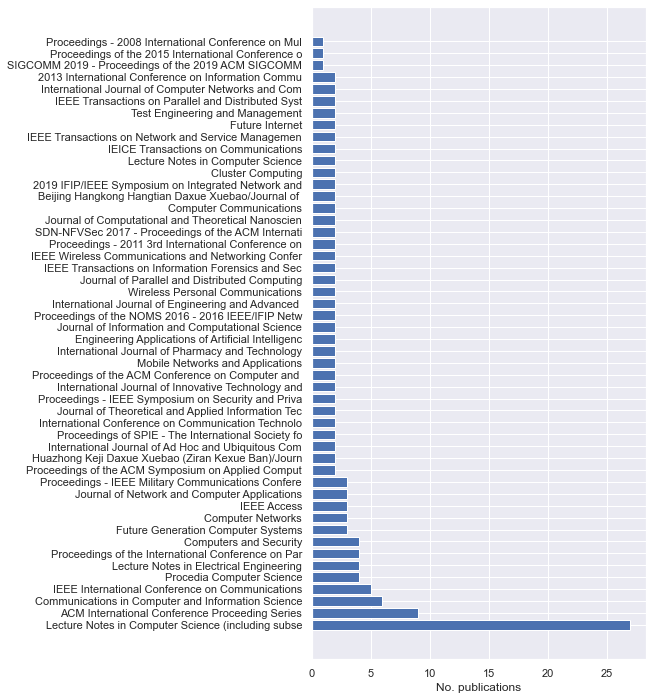

In [35]:
# Publications per publication source, conference/journal (TODO: cleaning!)
plot_statistic(lambda p: [p.publicationName])

# Topic Modeling
## Preprocessing

In [37]:
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 152 stopwords
loaded 42 bigrams
loaded 2 stem rules


In [38]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,3647,Yes
1,of,2379,Yes
2,and,2005,Yes
3,to,1758,Yes
4,a,1404,
5,in,1326,Yes
6,attacks,982,
7,ddos,959,
8,is,821,Yes
9,network,642,


In [39]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(ddos, attacks)",455,
1,"(distributed, denial)",236,
2,"(ddos, attack)",187,
3,"(service, ddos)",167,
4,"(intrusion, detection)",96,
5,"(against, ddos)",65,
6,"(a, distributed)",61,
7,"(a, collaborative)",59,
8,"(service, attacks)",57,
9,"(detection, system)",49,


In [40]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [41]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [42]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

INFO:root:stemming reduced 5401 to 3458 tokens


,Original,Stem,Unstem,Count
0,attacks,attack,attacks,982
1,ddos,ddo,ddos,959
2,network,network,network,642
3,attack,attack,attacks,614
4,detection,detect,detection,494
5,distributed,distribut,distributed,464
6,service,servic,service,382
7,security,secur,security,348
8,traffic,traffic,traffic,329
9,system,system,system,315


## Create dictionary

In [43]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = [papers[i] for i in indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 342 (removed 1)


In [44]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(3457 unique tokens: ['abnormal', 'against', 'algorithm', 'anomaly', 'approaches']...) from 342 documents (total 37203 corpus positions)
INFO:gensim.corpora.dictionary:discarding 9 tokens: [('attacks', 329), ('collaborative', 192), ('ddos', 321), ('denial', 223), ('detection', 207), ('distributed', 268), ('network', 259), ('service', 257), ('system', 190)]...
INFO:gensim.corpora.dictionary:keeping 3448 tokens which were in no less than 0 and no more than 171 (=50.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(3448 unique tokens: ['abnormal', 'against', 'algorithm', 'anomaly', 'approaches']...)
INFO:gensim.corpora.dictionary:discarding 2438 tokens: [('curbing', 1), ('lds', 1), ('ldses', 1), ('pure', 4), ('reactive', 3), ('blockade', 1), ('cn', 1), ('dcma', 1), ('don', 3), ('dual', 1)]...
INFO:gensim.corpora.dictionary:keeping 

papers: 342
dictionary size: 1010


## Topic modeling

In [45]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq
        

In [46]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [47]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

violation: 1.0
violation: 0.42591736936841257
violation: 0.27834969334279785
violation: 0.19638217974447733
violation: 0.14383512530685746
violation: 0.1101288977405119
violation: 0.08399270247108939
violation: 0.06433642735987356
violation: 0.05090321951813002
violation: 0.04172510035459427
violation: 0.03560733973316628
violation: 0.03148936654117514
violation: 0.028817275553078354
violation: 0.02685467100088085
violation: 0.025364962911628118
violation: 0.02412461706098067
violation: 0.023042319584976014
violation: 0.022058630567816734
violation: 0.020947989424486245
violation: 0.01991744388532553
violation: 0.018890439670661636
violation: 0.01788121659292098
violation: 0.01665071071585535
violation: 0.015347020654452427
violation: 0.01402986641577094
violation: 0.012825324641621913
violation: 0.011733805072284251
violation: 0.010731636463047043
violation: 0.00978922767298503
violation: 0.008893352092148981
violation: 0.008083583346143518
violation: 0.007347874206763908
violation: 0

violation: 0.0002268646628803444
violation: 0.00023432672545551324
violation: 0.000242073183765258
violation: 0.0002501105654111699
violation: 0.0002584039162588479
violation: 0.0002671013409544161
violation: 0.00027615015816121293
violation: 0.00028543919337220726
violation: 0.0002939591461779423
violation: 0.0003041902178367564
violation: 0.00031470220827054413
violation: 0.0003256158770876355
violation: 0.00033699417664562854
violation: 0.0003488591143638787
violation: 0.00036123287165169485
violation: 0.0003738959345654307
violation: 0.00038631998019747374
violation: 0.00039982090435809444
violation: 0.0004136131077744632
violation: 0.00042773754779656465
violation: 0.0004422312796733015
violation: 0.0004570238025588996
violation: 0.00047266442625268834
violation: 0.000488490840661638
violation: 0.0005055668523714077
violation: 0.0005238958624274309
violation: 0.0005433270958156089
violation: 0.0005630677475325091
violation: 0.0005839984756358752
violation: 0.0006056406769414688
vi

In [48]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,traffic (0.037),filtering (0.023),server (0.015),routers (0.014),flow (0.013),target (0.012),algorithm (0.01),legitimate (0.0099),client (0.0097),isp (0.0094)
1,B,cloud (0.084),computing (0.026),environment (0.018),ids (0.014),framework (0.01),users (0.0097),dos (0.0097),business (0.0086),resources (0.0072),malicious (0.0069)
2,C,sdn (0.069),control (0.031),plane (0.03),software (0.022),defined (0.021),mitigation (0.017),framework (0.011),scheme (0.011),switches (0.011),data (0.0096)
3,D,defense (0.068),mechanism (0.022),against (0.02),cooperative (0.016),agent (0.012),resources (0.011),effective (0.01),internet (0.0097),blockchain (0.0093),end (0.0081)
4,E,botnet (0.1),bots (0.02),control (0.014),monitoring (0.013),rules (0.013),automatically (0.012),collection (0.011),active (0.0094),command (0.0093),analysis (0.0088)
5,F,alerts (0.054),correlation (0.041),intrusion (0.036),idss (0.027),cooperative (0.02),coordinated (0.014),cids (0.014),hosts (0.012),ids (0.011),internet (0.01)
6,G,model (0.053),defend (0.04),game (0.036),agent (0.026),active (0.016),learning (0.015),strategy (0.015),differential (0.013),theoretic (0.011),theory (0.01)
7,H,nodes (0.036),mobile (0.033),manet (0.031),wireless (0.026),hoc (0.022),ad (0.02),energy (0.017),trust (0.014),self (0.013),decentralized (0.01)
8,I,packet (0.047),marking (0.035),ip (0.031),traceback (0.029),spoofing (0.025),scheme (0.02),filtering (0.015),trace (0.014),source (0.014),dos (0.011)
9,J,iot (0.076),devices (0.046),things (0.019),smart (0.015),blockchain (0.014),internet (0.013),home (0.012),solutions (0.0094),numerous (0.009),security (0.0077)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


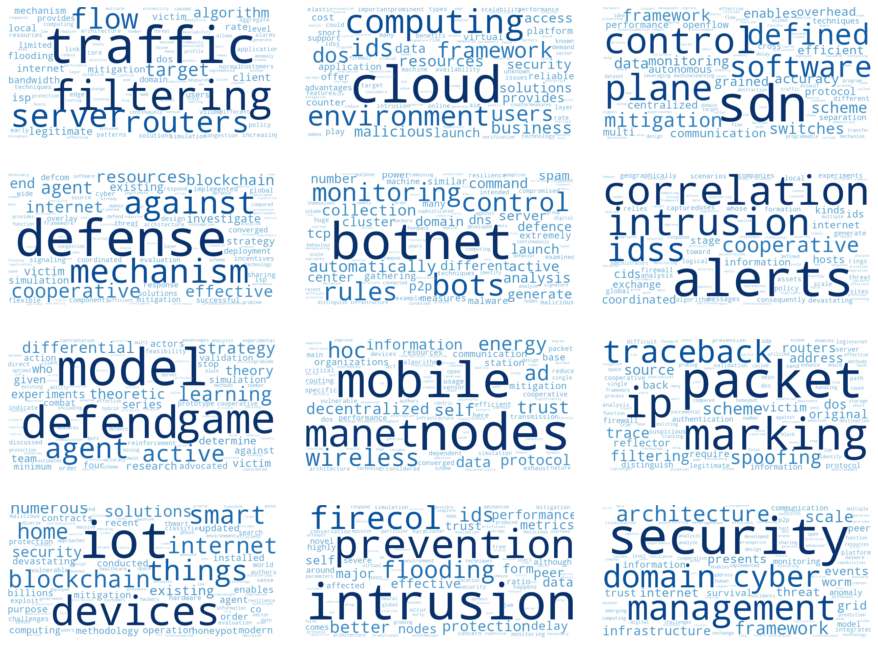

In [49]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()


## Visualization

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 342 samples in 0.000s...
[t-SNE] Computed neighbors for 342 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 342 / 342
[t-SNE] Mean sigma: 0.209879
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.107567
[t-SNE] KL divergence after 1000 iterations: 0.660385


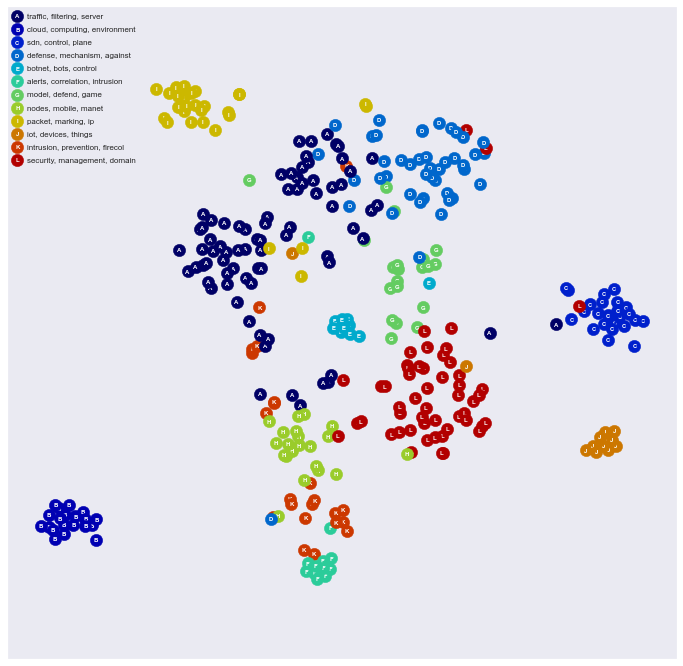

In [50]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

In [51]:
def on_select(i):
    p = papers[i]
    print(p.title)
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p.abstract)

options = sorted([((p.title or '').strip()[:50], i) for i, p in enumerate(papers)])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
widget

interactive(children=(Dropdown(description='i', options=(('A Bayesian Game-Theoretic Intrusion Detection Syst'…

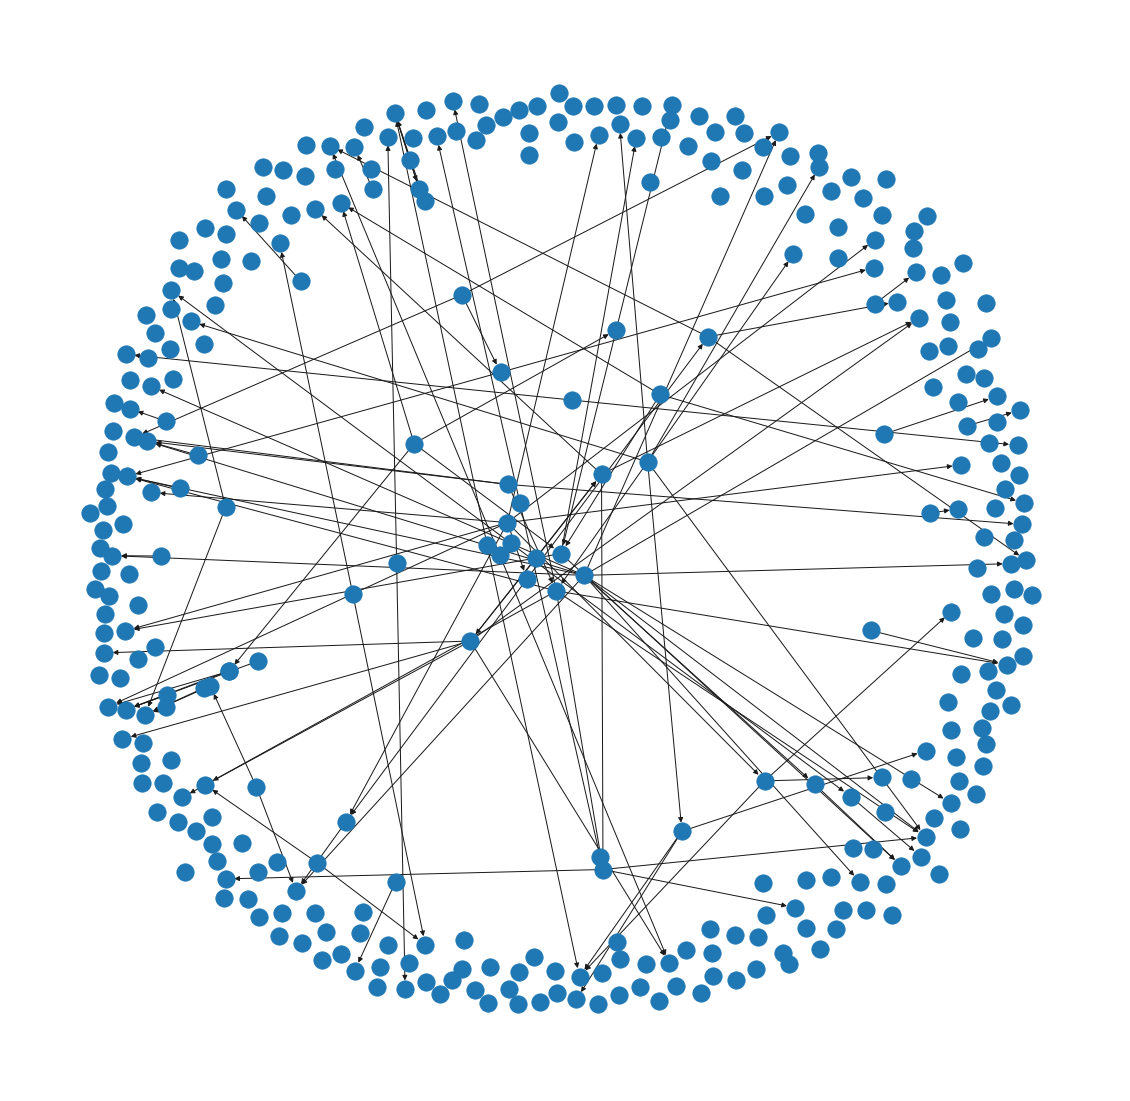

In [66]:
from IPython.display import Image
Image(filename='paper_net_relationship.png') 

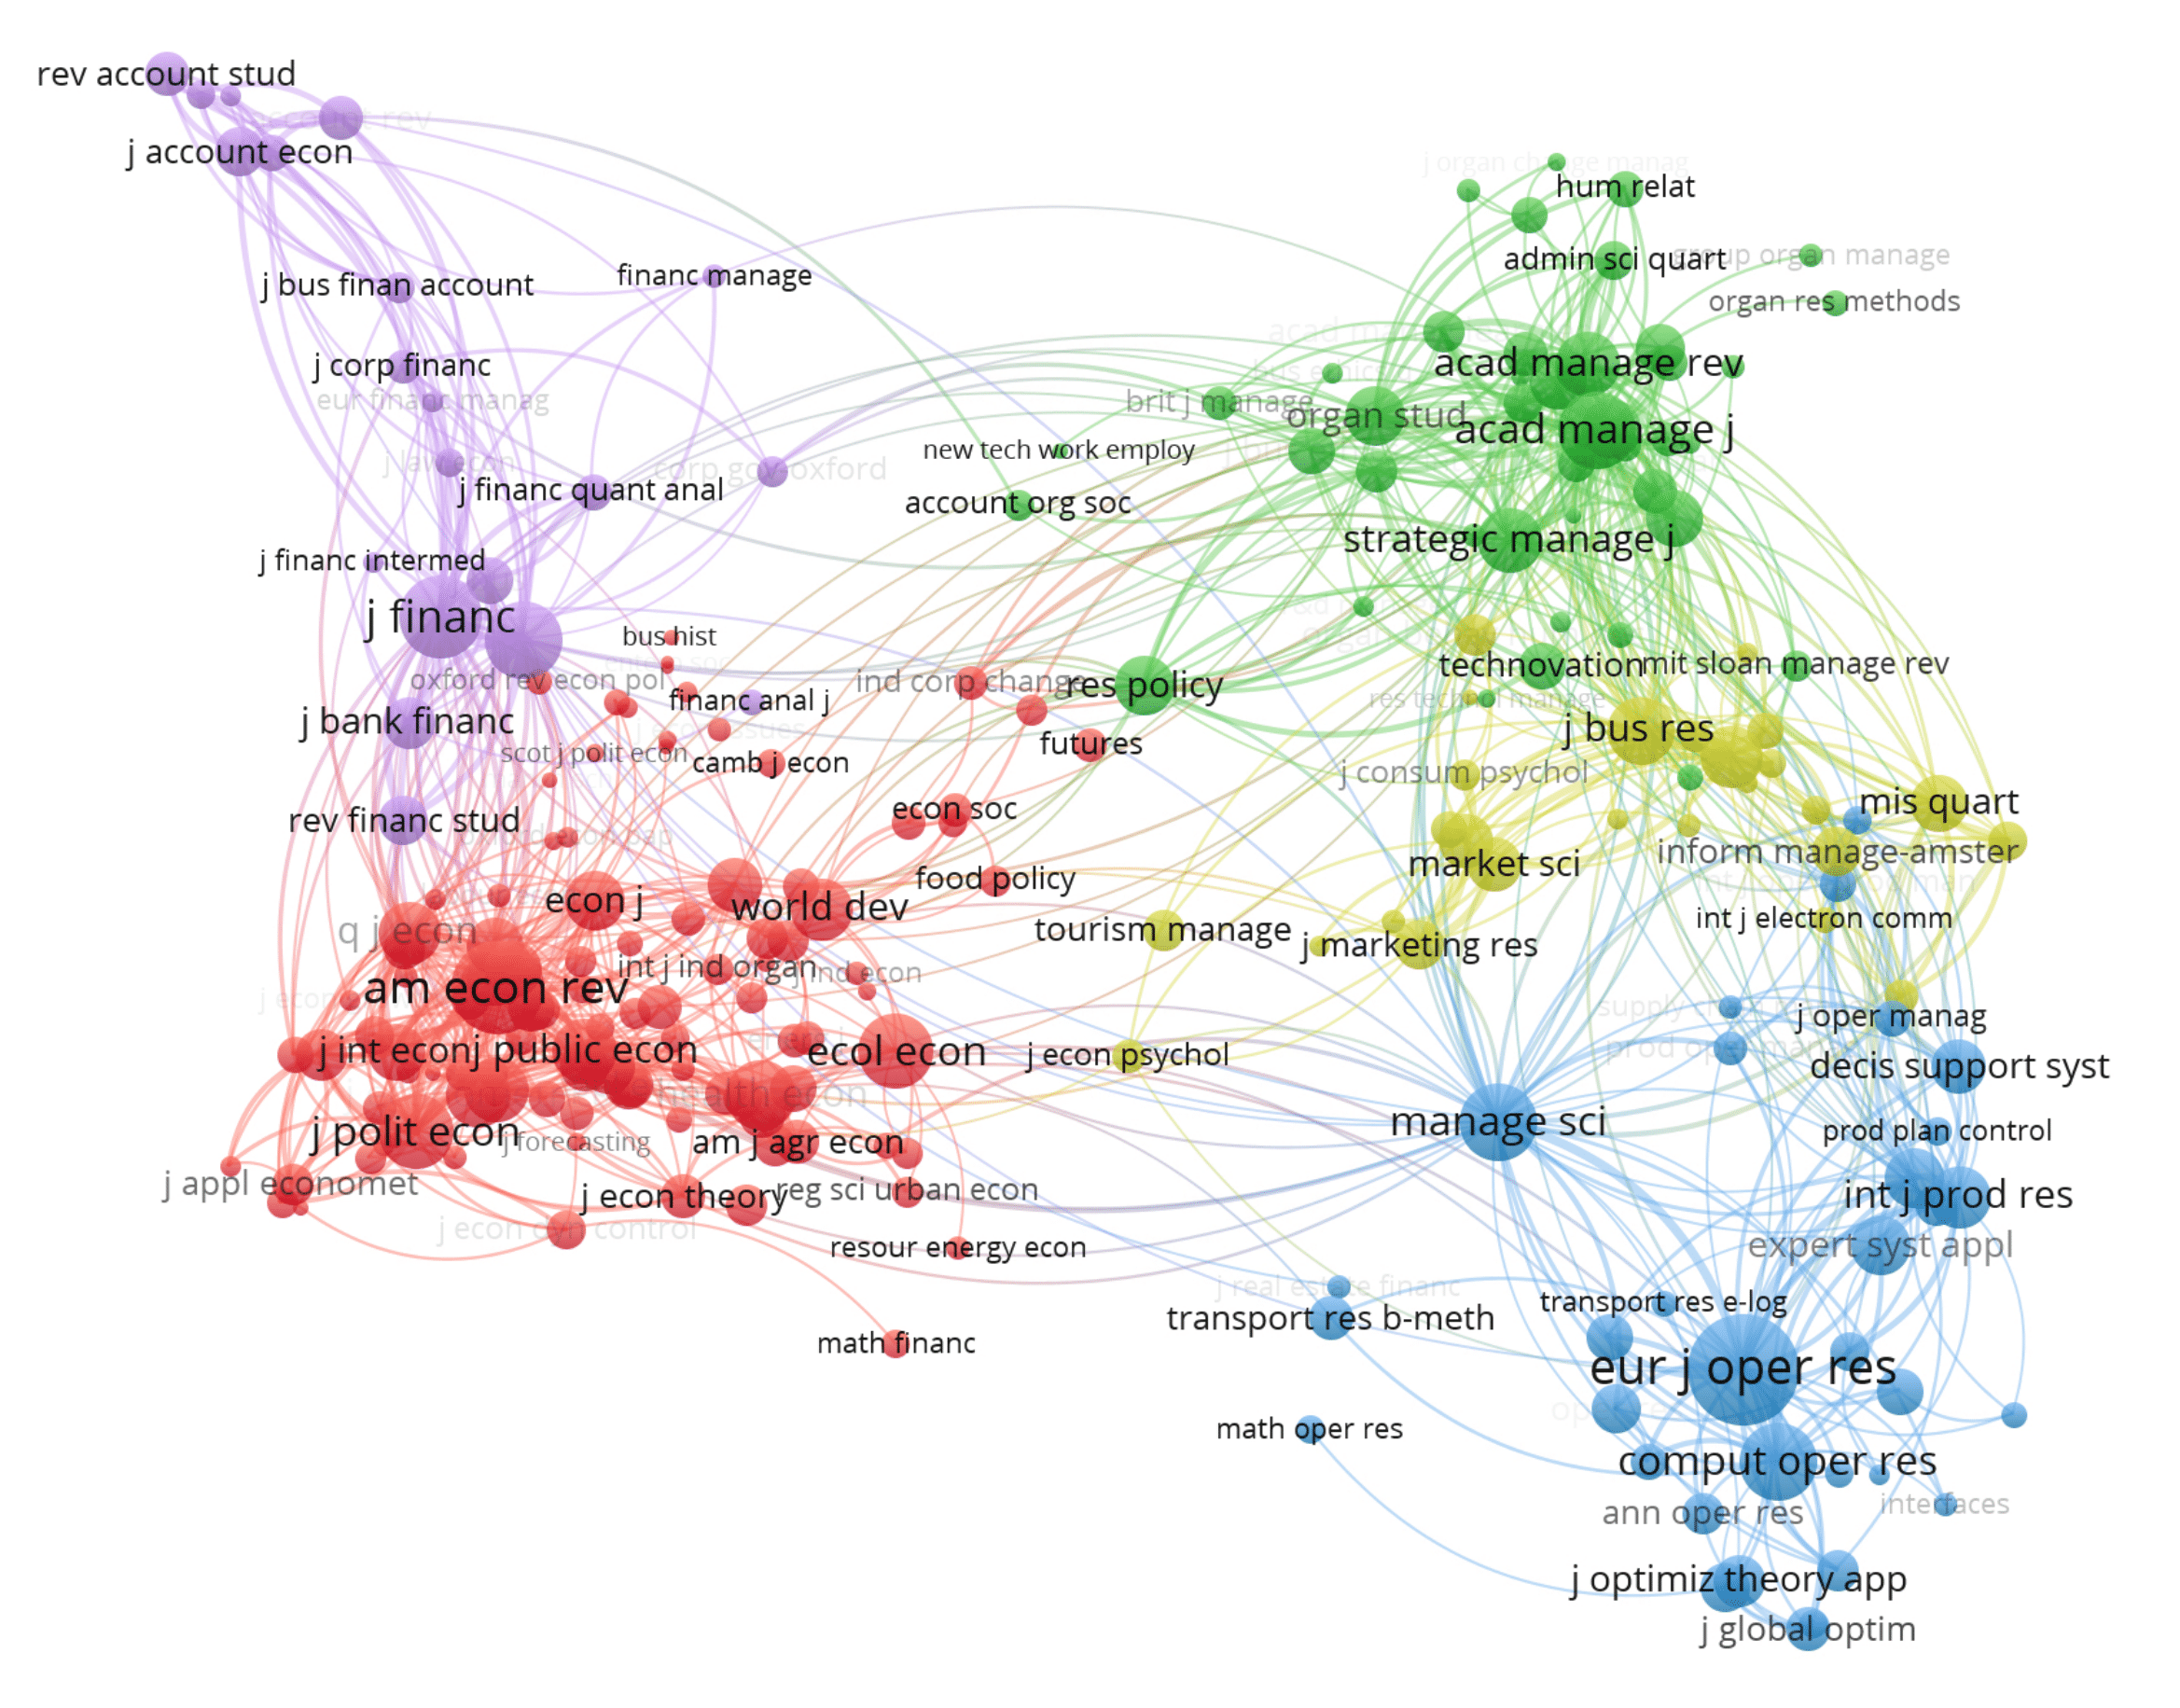

In [69]:
from IPython.display import Image
Image(filename='vosviewer.png') 